# Notebook 1: Data Exploration & Match Selection

## Goal
Understand data structure, validate quality, and confirm target match for Bayesian analysis.

## Research Question
Does updating Bayesian posteriors with in-game technical statistics (First Serve %, Ace Rate) reduce uncertainty in point-level win probability (θ) faster than a score-based baseline?

## Target Match
- **Match ID**: 2024-wimbledon-1501
- **Players**: Jannik Sinner vs Daniil Medvedev
- **Expected Points**: ~326

## 1. Setup & Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

print("✅ Imports successful")

✅ Imports successful


## 2. Load Data

In [25]:
# Data paths
DATA_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/data')

# Load 2023 data (for priors)
matches_2023 = pd.read_csv(DATA_DIR / '2023-wimbledon-matches.csv')
points_2023 = pd.read_csv(DATA_DIR / '2023-wimbledon-points.csv')

# Load 2024 data (target match)
matches_2024 = pd.read_csv(DATA_DIR / '2024-wimbledon-matches.csv')
points_2024 = pd.read_csv(DATA_DIR / '2024-wimbledon-points.csv')

print(f"2023 Matches: {len(matches_2023)} rows")
print(f"2023 Points: {len(points_2023)} rows")
print(f"2024 Matches: {len(matches_2024)} rows")
print(f"2024 Points: {len(points_2024)} rows")

2023 Matches: 254 rows
2023 Points: 48676 rows
2024 Matches: 252 rows
2024 Points: 48155 rows


## 3. Initial Data Quality Assessment

In [26]:
# Check critical columns in points data
critical_cols = ['match_id', 'PointNumber', 'PointServer', 'PointWinner', 
                 'ServeNumber', 'P1FirstSrvIn', 'P2FirstSrvIn', 'P1Ace', 'P2Ace']

print("Missing values in critical columns (2024):")
missing_2024 = points_2024[critical_cols].isnull().sum()
print(missing_2024[missing_2024 > 0])

print("\nMissing values in critical columns (2023):")
missing_2023 = points_2023[critical_cols].isnull().sum()
print(missing_2023[missing_2023 > 0])

# Assess ServeNumber column
print("\n📊 ServeNumber distribution (2024):")
print(points_2024['ServeNumber'].value_counts().sort_index())
print("\n✅ ServeNumber column is fully populated - can reconstruct first serve stats")

Missing values in critical columns (2024):
P1FirstSrvIn    48155
P2FirstSrvIn    48155
dtype: int64

Missing values in critical columns (2023):
P1FirstSrvIn    48676
P2FirstSrvIn    48676
dtype: int64

📊 ServeNumber distribution (2024):
ServeNumber
0     2386
1    30022
2    15747
Name: count, dtype: int64

✅ ServeNumber column is fully populated - can reconstruct first serve stats


## 4. Fix Missing First Serve Data

**CRITICAL ISSUE DETECTED**: P1FirstSrvIn and P2FirstSrvIn columns are completely empty (all NaN).

**Solution**: Calculate from ServeNumber column.

**CORRECTED Logic** (per-point, no adjacent-row lookups):
- Each point is a **single row** with ServeNumber already set
- `ServeNumber == 1` → Point won/lost on first serve (first serve was IN)
- `ServeNumber == 2` → Point went to second serve (first serve was OUT)
- `ServeNumber == 0` → Metadata row (skip)

**Key Fix**: We count first serve attempts on BOTH ServeNumber=1 and ServeNumber=2. We only count first serves IN when ServeNumber=1.

In [27]:
def calculate_first_serve_stats(points_df):
    """
    Calculate cumulative first serve statistics from ServeNumber column.
    
    CORRECTED LOGIC (per-point):
    - ServeNumber=1: First serve IN (increment attempts AND in)
    - ServeNumber=2: First serve OUT (increment attempts only)
    - ServeNumber=0: Metadata (skip)
    
    Args:
        points_df: DataFrame with match-point data
    
    Returns:
        DataFrame with P1FirstSrvIn, P1FirstSrvTotal, P2FirstSrvIn, P2FirstSrvTotal
    """
    df = points_df.copy()
    
    # Initialize new columns
    df['P1FirstSrvIn'] = 0
    df['P2FirstSrvIn'] = 0
    df['P1FirstSrvTotal'] = 0
    df['P2FirstSrvTotal'] = 0
    
    # Process each match separately
    for match_id in df['match_id'].unique():
        match_mask = df['match_id'] == match_id
        match_points = df[match_mask].copy()
        
        # Tracking variables
        p1_first_in = 0
        p1_first_total = 0
        p2_first_in = 0
        p2_first_total = 0
        
        cumulative_values = []
        
        for idx, row in match_points.iterrows():
            server = row['PointServer']
            serve_num = row['ServeNumber']
            
            # Process based on ServeNumber
            if serve_num == 0:
                # Metadata row - don't increment anything
                pass
            elif serve_num == 1:
                # First serve IN
                if server == 1:
                    p1_first_total += 1
                    p1_first_in += 1
                elif server == 2:
                    p2_first_total += 1
                    p2_first_in += 1
            elif serve_num == 2:
                # Second serve (first serve was OUT)
                if server == 1:
                    p1_first_total += 1
                    # p1_first_in stays same
                elif server == 2:
                    p2_first_total += 1
                    # p2_first_in stays same
            
            # Store cumulative values for this row
            cumulative_values.append({
                'idx': idx,
                'p1_in': p1_first_in,
                'p1_total': p1_first_total,
                'p2_in': p2_first_in,
                'p2_total': p2_first_total
            })
        
        # Assign back to dataframe
        for val in cumulative_values:
            df.loc[val['idx'], 'P1FirstSrvIn'] = val['p1_in']
            df.loc[val['idx'], 'P1FirstSrvTotal'] = val['p1_total']
            df.loc[val['idx'], 'P2FirstSrvIn'] = val['p2_in']
            df.loc[val['idx'], 'P2FirstSrvTotal'] = val['p2_total']
    
    return df

print("✅ Function defined: calculate_first_serve_stats (CORRECTED)")

✅ Function defined: calculate_first_serve_stats (CORRECTED)


In [28]:
# Calculate for 2024 data
print("Calculating first serve stats for 2024 data...")
points_2024 = calculate_first_serve_stats(points_2024)

# Verify calculation with first match
print("\nSample of calculated stats (2024 - first match):")
sample_match = points_2024['match_id'].iloc[0]
sample_cols = ['match_id', 'PointNumber', 'PointServer', 'ServeNumber',
               'P1FirstSrvIn', 'P1FirstSrvTotal', 'P2FirstSrvIn', 'P2FirstSrvTotal']
print(points_2024[points_2024['match_id'] == sample_match][sample_cols].head(20))

Calculating first serve stats for 2024 data...

Sample of calculated stats (2024 - first match):
               match_id PointNumber  PointServer  ServeNumber  P1FirstSrvIn  P1FirstSrvTotal  P2FirstSrvIn  P2FirstSrvTotal
0   2024-wimbledon-1101          0X            0            0             0                0             0                0
1   2024-wimbledon-1101          0Y            0            0             0                0             0                0
2   2024-wimbledon-1101           1            1            1             1                1             0                0
3   2024-wimbledon-1101           2            1            0             1                1             0                0
4   2024-wimbledon-1101           3            1            1             2                2             0                0
5   2024-wimbledon-1101           4            1            1             3                3             0                0
6   2024-wimbledon-1101           5

In [29]:
# Calculate for 2023 data (needed for priors)
print("Calculating first serve stats for 2023 data...")
points_2023 = calculate_first_serve_stats(points_2023)

print("✅ First serve statistics calculated for both 2023 and 2024 datasets")

Calculating first serve stats for 2023 data...
✅ First serve statistics calculated for both 2023 and 2024 datasets


## 5. Validation: Verify First Serve Percentages

**Strict Validation**: Check all matches, fail if >10% are outside realistic range

In [30]:
# Validation function
def validate_first_serve_percentages(points_df, dataset_name, sample_size=20, fail_threshold=0.1):
    """
    Validate first serve percentages across matches.
    
    Args:
        points_df: DataFrame with calculated first serve stats
        dataset_name: Name for reporting (e.g., '2024')
        sample_size: Number of matches to check
        fail_threshold: Fraction of failures to trigger error (0.1 = 10%)
    
    Returns:
        bool: True if validation passes
    """
    print(f"Validation: First Serve % for {dataset_name} (checking {sample_size} matches)\n")
    
    validation_results = []
    match_ids = points_df['match_id'].unique()[:sample_size]
    
    for match_id in match_ids:
        match_final = points_df[points_df['match_id'] == match_id].iloc[-1]
        
        p1_pct = (match_final['P1FirstSrvIn'] / match_final['P1FirstSrvTotal'] 
                  if match_final['P1FirstSrvTotal'] > 0 else 0)
        p2_pct = (match_final['P2FirstSrvIn'] / match_final['P2FirstSrvTotal'] 
                  if match_final['P2FirstSrvTotal'] > 0 else 0)
        
        # Realistic range: 50-80%
        p1_valid = 0.50 <= p1_pct <= 0.80
        p2_valid = 0.50 <= p2_pct <= 0.80
        both_valid = p1_valid and p2_valid
        
        validation_results.append({
            'match_id': match_id,
            'P1_pct': p1_pct,
            'P2_pct': p2_pct,
            'valid': both_valid
        })
        
        status = "✅" if both_valid else "❌"
        print(f"{status} {match_id}: P1={p1_pct:.1%}, P2={p2_pct:.1%}")
    
    val_df = pd.DataFrame(validation_results)
    pass_count = val_df['valid'].sum()
    fail_count = len(val_df) - pass_count
    fail_rate = fail_count / len(val_df)
    
    print(f"\n{'='*60}")
    print(f"Results: {pass_count}/{len(val_df)} matches passed validation")
    print(f"Failure rate: {fail_rate:.1%} (threshold: {fail_threshold:.1%})")
    
    if fail_rate > fail_threshold:
        print(f"\n❌ VALIDATION FAILED: Too many matches outside realistic range")
        print(f"   Failing matches: {list(val_df[~val_df['valid']]['match_id'].values)}")
        print(f"\n⚠️  DO NOT PROCEED - Fix calculation logic before saving data")
        return False
    else:
        print(f"\n✅ VALIDATION PASSED: Calculation appears correct")
        return True

# Run validation on both datasets
valid_2024 = validate_first_serve_percentages(points_2024, '2024', sample_size=20)
print("\n" + "="*60 + "\n")
valid_2023 = validate_first_serve_percentages(points_2023, '2023', sample_size=20)

Validation: First Serve % for 2024 (checking 20 matches)

✅ 2024-wimbledon-1101: P1=59.3%, P2=70.3%
✅ 2024-wimbledon-1102: P1=65.8%, P2=64.1%
✅ 2024-wimbledon-1103: P1=67.5%, P2=61.2%
✅ 2024-wimbledon-1104: P1=68.6%, P2=61.4%
✅ 2024-wimbledon-1105: P1=61.5%, P2=66.7%
✅ 2024-wimbledon-1106: P1=58.6%, P2=65.0%
✅ 2024-wimbledon-1107: P1=64.1%, P2=75.3%
✅ 2024-wimbledon-1108: P1=53.9%, P2=75.0%
✅ 2024-wimbledon-1109: P1=58.5%, P2=70.7%
✅ 2024-wimbledon-1110: P1=64.4%, P2=67.7%
✅ 2024-wimbledon-1111: P1=57.7%, P2=68.1%
✅ 2024-wimbledon-1112: P1=65.8%, P2=64.7%
✅ 2024-wimbledon-1113: P1=60.4%, P2=73.6%
✅ 2024-wimbledon-1114: P1=59.1%, P2=60.5%
✅ 2024-wimbledon-1115: P1=74.5%, P2=57.9%
✅ 2024-wimbledon-1116: P1=66.2%, P2=68.8%
✅ 2024-wimbledon-1117: P1=65.9%, P2=69.0%
✅ 2024-wimbledon-1118: P1=62.1%, P2=58.5%
✅ 2024-wimbledon-1119: P1=61.4%, P2=67.1%
✅ 2024-wimbledon-1120: P1=69.4%, P2=61.9%

Results: 20/20 matches passed validation
Failure rate: 0.0% (threshold: 10.0%)

✅ VALIDATION PASSED: 

In [31]:
# Hard stop if validation failed
if not (valid_2024 and valid_2023):
    raise ValueError("Validation failed - calculation logic is incorrect. Do not save data.")
else:
    print("✅ Both datasets passed validation - safe to save corrected files")

✅ Both datasets passed validation - safe to save corrected files


## 6. Save Corrected Datasets

**CRITICAL**: Only save canonical columns (no duplicate _calc columns)

In [32]:
# Create corrected directory
CORRECTED_DIR = DATA_DIR / 'corrected'
CORRECTED_DIR.mkdir(exist_ok=True)

# Save corrected versions (only canonical columns, no duplicates)
points_2024.to_csv(CORRECTED_DIR / '2024-wimbledon-points-corrected.csv', index=False)
points_2023.to_csv(CORRECTED_DIR / '2023-wimbledon-points-corrected.csv', index=False)

print(f"✅ Corrected datasets saved to: {CORRECTED_DIR}")
print("   - 2024-wimbledon-points-corrected.csv")
print("   - 2023-wimbledon-points-corrected.csv")
print("\n⚠️  IMPORTANT: All downstream notebooks MUST use corrected files!")

✅ Corrected datasets saved to: /Users/egeaydin/Github/TUW2025WS/aip_ege/data/corrected
   - 2024-wimbledon-points-corrected.csv
   - 2023-wimbledon-points-corrected.csv

⚠️  IMPORTANT: All downstream notebooks MUST use corrected files!


## 7. Re-check Data Quality (After Correction)

**Verify BOTH 2023 and 2024 datasets are complete**

In [33]:
# Re-check missing values for 2024
print("Missing values in critical columns after correction (2024):")
missing_2024_after = points_2024[critical_cols].isnull().sum()
print(missing_2024_after[missing_2024_after > 0])
if missing_2024_after.sum() == 0:
    print("✅ 2024: All critical columns complete")

# Re-check missing values for 2023
print("\nMissing values in critical columns after correction (2023):")
missing_2023_after = points_2023[critical_cols].isnull().sum()
print(missing_2023_after[missing_2023_after > 0])
if missing_2023_after.sum() == 0:
    print("✅ 2023: All critical columns complete")

# Final verdict
if missing_2024_after.sum() == 0 and missing_2023_after.sum() == 0:
    print("\n✅ DATA QUALITY CHECK PASSED: All critical columns complete in both datasets")
else:
    print("\n⚠️  DATA QUALITY ISSUE: Some columns still missing")

Missing values in critical columns after correction (2024):
Series([], dtype: int64)
✅ 2024: All critical columns complete

Missing values in critical columns after correction (2023):
Series([], dtype: int64)
✅ 2023: All critical columns complete

✅ DATA QUALITY CHECK PASSED: All critical columns complete in both datasets


## 8. Match Analysis - 2024 Wimbledon

In [34]:
# Calculate match lengths (point counts)
match_lengths = points_2024.groupby('match_id').size().reset_index(name='point_count')

# Merge with match metadata
match_summary = matches_2024.merge(match_lengths, on='match_id', how='left')

print(f"Total 2024 matches with point data: {len(match_summary[match_summary['point_count'].notna()])}")
print(f"\nMatch length statistics:")
print(match_summary['point_count'].describe())

Total 2024 matches with point data: 252

Match length statistics:
count    252.000000
mean     191.091270
std       76.517709
min       21.000000
25%      128.750000
50%      177.000000
75%      242.000000
max      379.000000
Name: point_count, dtype: float64


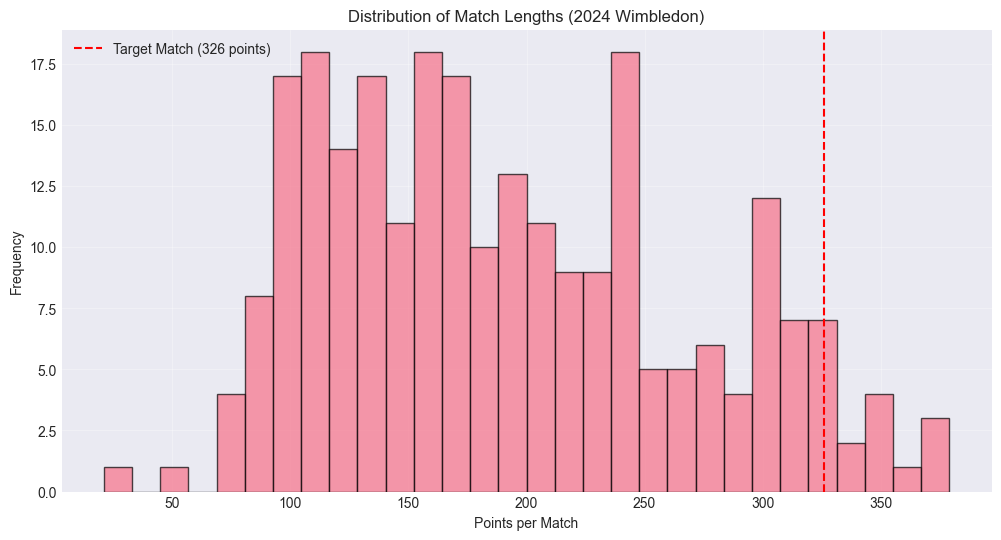

In [35]:
# Visualize match lengths
plt.figure(figsize=(12, 6))
plt.hist(match_summary['point_count'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Points per Match')
plt.ylabel('Frequency')
plt.title('Distribution of Match Lengths (2024 Wimbledon)')
plt.axvline(326, color='red', linestyle='--', label='Target Match (326 points)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 9. Target Match Selection & Validation

In [36]:
# Target match ID
TARGET_MATCH_ID = '2024-wimbledon-1501'

# Get target match metadata
target_match_meta = matches_2024[matches_2024['match_id'] == TARGET_MATCH_ID]

if len(target_match_meta) == 0:
    print(f"❌ ERROR: Match {TARGET_MATCH_ID} not found in matches data")
else:
    print("✅ Target match found:")
    print(target_match_meta[['match_id', 'player1', 'player2', 'round', 'winner']].T)
    
    # Check for missing metadata (without speculation)
    if pd.isna(target_match_meta['round'].values[0]):
        print("\nℹ️  Round information: Not available in metadata")
    
    if pd.isna(target_match_meta['winner'].values[0]):
        print("ℹ️  Winner information: Not available in metadata")

✅ Target match found:
                          119
match_id  2024-wimbledon-1501
player1         Jannik Sinner
player2       Daniil Medvedev
round                     NaN
winner                    NaN

ℹ️  Round information: Not available in metadata
ℹ️  Winner information: Not available in metadata


In [37]:
# Extract target match points
target_points = points_2024[points_2024['match_id'] == TARGET_MATCH_ID].copy()

print(f"Target match point count: {len(target_points)}")
print(f"Expected: ~326 points")

if len(target_points) > 300:
    print("✅ Point count looks reasonable for a high-level match")
else:
    print("⚠️  Lower than expected point count - investigate")

Target match point count: 326
Expected: ~326 points
✅ Point count looks reasonable for a high-level match


In [38]:
# Display first few points
print("First 10 points of target match:")
display_cols = ['match_id', 'PointNumber', 'PointServer', 'PointWinner', 'ServeNumber',
                'P1FirstSrvIn', 'P1FirstSrvTotal', 'P2FirstSrvIn', 'P2FirstSrvTotal']
target_points[display_cols].head(10)

First 10 points of target match:


,match_id,PointNumber,PointServer,PointWinner,ServeNumber,P1FirstSrvIn,P1FirstSrvTotal,P2FirstSrvIn,P2FirstSrvTotal
28792,2024-wimbledon-1501,0X,0,0,0,0,0,0,0
28793,2024-wimbledon-1501,0Y,0,0,0,0,0,0,0
28794,2024-wimbledon-1501,1,2,1,1,0,0,1,1
28795,2024-wimbledon-1501,2,2,1,0,0,0,1,1
28796,2024-wimbledon-1501,3,2,2,1,0,0,2,2
28797,2024-wimbledon-1501,4,2,2,2,0,0,2,3
28798,2024-wimbledon-1501,5,2,2,1,0,0,3,4
28799,2024-wimbledon-1501,6,2,1,1,0,0,4,5
28800,2024-wimbledon-1501,7,2,2,1,0,0,5,6
28801,2024-wimbledon-1501,8,2,2,2,0,0,5,7


## 10. Tiebreak Validation

**Why This Matters**: In tiebreaks, server switches every 2 points (not every game). If `PointServer` is incorrectly assigned during tiebreaks, cumulative statistics will be attributed to the wrong player.

**Method**: Check if P1Score/P2Score columns exist; if so, look for tiebreak patterns. If not, use serve-switching heuristics.

In [39]:
# Check if score columns exist
if 'P1Score' in target_points.columns and 'P2Score' in target_points.columns:
    print("✅ P1Score/P2Score columns available")
    
    # Look for tiebreak indicators (6-6, 7-6 game scores)
    # Convert to string for pattern matching
    target_points_copy = target_points.copy()
    target_points_copy['P1Score_str'] = target_points_copy['P1Score'].astype(str)
    target_points_copy['P2Score_str'] = target_points_copy['P2Score'].astype(str)
    
    # Tiebreak pattern: look for "6-6" or "7-6" in score strings
    tiebreak_candidates = target_points_copy[
        target_points_copy['P1Score_str'].str.contains('6-6|7-6', na=False, regex=True) |
        target_points_copy['P2Score_str'].str.contains('6-6|7-6', na=False, regex=True)
    ]
    
    if len(tiebreak_candidates) > 0:
        print(f"\n⚠️  Found {len(tiebreak_candidates)} potential tiebreak points")
        print("\nValidating PointServer switching every 2 points (tiebreak rule):")
        
        # Reset index to get sequential row numbers for checking switching
        tb = tiebreak_candidates.reset_index(drop=True)
        servers = tb['PointServer'].values
        
        # Expected pattern: [1,1,2,2,1,1,2,2,...] (switch every 2 points)
        print(f"Server sequence (first 20): {servers[:20].tolist()}")
        
        # Check for violations (server changes NOT every 2 points)
        violations = []
        for i in range(1, min(len(servers), 20)):
            if i % 2 == 0:  # Every 2nd point should switch
                if servers[i] == servers[i-1]:
                    violations.append(f"Point {i}: Expected switch, got {servers[i-1]} → {servers[i]}")
            else:  # Every other point should stay same
                if servers[i] != servers[i-1]:
                    violations.append(f"Point {i}: Expected same, got {servers[i-1]} → {servers[i]}")
        
        if len(violations) > 0:
            print(f"\n❌ TIEBREAK VALIDATION FAILED: {len(violations)} violations detected")
            for v in violations[:5]:
                print(f"   {v}")
            print("\n⚠️  PointServer may be incorrect during tiebreaks - model may produce invalid results")
        else:
            print("\n✅ Tiebreak server switching follows correct pattern (every 2 points)")
    else:
        print("\nℹ️  No tiebreaks detected in target match (all games ended before 6-6)")
else:
    print("⚠️  P1Score/P2Score columns not available")
    print("\nUsing fallback: Analyze server switching intervals...")
    
    # Reset index for proper row-number-based analysis
    tp_reset = target_points.reset_index(drop=True)
    tp_reset['server_change'] = tp_reset['PointServer'].diff()
    
    # Get indices where server changed
    switches = tp_reset[tp_reset['server_change'] != 0].copy()
    switches['row_num'] = switches.index
    switches['points_since_last_switch'] = switches['row_num'].diff()
    
    # Short intervals (≤3 points) may indicate tiebreak
    short_intervals = switches[switches['points_since_last_switch'] <= 3]
    
    if len(short_intervals) > 5:
        print(f"\n⚠️  Found {len(short_intervals)} server switches with ≤3 point intervals")
        print("   May indicate tiebreak(s) - but cannot confirm without score data")
        print("\n   Sample:")
        print(short_intervals[['PointNumber', 'PointServer', 'points_since_last_switch']].head(10))
    else:
        print("\nℹ️  Server switching intervals look normal (standard game patterns)")
    
    print("\n⚠️  Note: Without score columns, tiebreak detection is approximate")
    print("   If first serve stats look anomalous, revisit this validation")

✅ P1Score/P2Score columns available

ℹ️  No tiebreaks detected in target match (all games ended before 6-6)


## 11. Verify 2023 Historical Data Availability

In [40]:
# Extract player names from target match
player1 = target_match_meta['player1'].values[0]
player2 = target_match_meta['player2'].values[0]

print(f"Target players: {player1} vs {player2}")

# Check 2023 data for both players
player1_2023_matches = matches_2023[
    (matches_2023['player1'] == player1) | (matches_2023['player2'] == player1)
]

player2_2023_matches = matches_2023[
    (matches_2023['player1'] == player2) | (matches_2023['player2'] == player2)
]

print(f"\n{player1} in 2023: {len(player1_2023_matches)} matches")
print(f"{player2} in 2023: {len(player2_2023_matches)} matches")

if len(player1_2023_matches) > 0 and len(player2_2023_matches) > 0:
    print("\n✅ Both players have 2023 data - good for prior extraction")
else:
    print("\n⚠️  At least one player missing from 2023 data - may need tournament-level priors")

Target players: Jannik Sinner vs Daniil Medvedev

Jannik Sinner in 2023: 6 matches
Daniil Medvedev in 2023: 6 matches

✅ Both players have 2023 data - good for prior extraction


In [41]:
# Show which rounds they played in 2023
print(f"\n{player1} 2023 matches:")
print(player1_2023_matches[['match_id', 'player1', 'player2', 'round', 'winner']])

print(f"\n{player2} 2023 matches:")
print(player2_2023_matches[['match_id', 'player1', 'player2', 'round', 'winner']])


Jannik Sinner 2023 matches:
                match_id        player1                player2  round  winner
32   2023-wimbledon-1133  Jannik Sinner  Juan Manuel Cerundolo    NaN     NaN
80   2023-wimbledon-1217  Jannik Sinner      Diego Schwartzman    NaN     NaN
104  2023-wimbledon-1309  Jannik Sinner          Quentin Halys    NaN     NaN
116  2023-wimbledon-1405  Jannik Sinner     Daniel Elahi Galan    NaN     NaN
122  2023-wimbledon-1503  Jannik Sinner        Roman Safiullin    NaN     NaN
125  2023-wimbledon-1602  Jannik Sinner         Novak Djokovic    NaN     NaN

Daniil Medvedev 2023 matches:
                match_id          player1              player2  round  winner
16   2023-wimbledon-1117  Daniil Medvedev          Arthur Fery    NaN     NaN
72   2023-wimbledon-1209  Daniil Medvedev     Adrian Mannarino    NaN     NaN
100  2023-wimbledon-1305  Daniil Medvedev     Marton Fucsovics    NaN     NaN
114  2023-wimbledon-1403  Daniil Medvedev         Jiri Lehecka    NaN     NaN
121 

In [42]:
# Calculate total points served by each player in 2023
player1_match_ids = player1_2023_matches['match_id'].values
player2_match_ids = player2_2023_matches['match_id'].values

player1_points_2023 = points_2023[points_2023['match_id'].isin(player1_match_ids)]
player2_points_2023 = points_2023[points_2023['match_id'].isin(player2_match_ids)]

print(f"\n{player1} total points in 2023: {len(player1_points_2023)}")
print(f"{player2} total points in 2023: {len(player2_points_2023)}")

if len(player1_points_2023) > 500 and len(player2_points_2023) > 500:
    print("\n✅ Sufficient data for robust player-specific priors (>500 points each)")
elif len(player1_points_2023) > 100 and len(player2_points_2023) > 100:
    print("\n⚠️  Moderate data - consider blending with tournament priors (100-500 points)")
else:
    print("\n⚠️  Sparse data - use tournament-level priors (<100 points)")


Jannik Sinner total points in 2023: 1144
Daniil Medvedev total points in 2023: 1210

✅ Sufficient data for robust player-specific priors (>500 points each)


## 12. Target Match Statistics

In [43]:
# Calculate final serve stats for target match
target_final = target_points.iloc[-1]

print("Target Match Final Statistics:")
print(f"\nPlayer 1 ({player1}):")
if target_final['P1FirstSrvTotal'] > 0:
    srv_pct = target_final['P1FirstSrvIn'] / target_final['P1FirstSrvTotal']
    print(f"  First Serves In: {target_final['P1FirstSrvIn']:.0f} / {target_final['P1FirstSrvTotal']:.0f} = {srv_pct:.1%}")
print(f"  Aces: {target_final['P1Ace']:.0f}")
print(f"  Points Won: {target_final['P1PointsWon']:.0f}")

print(f"\nPlayer 2 ({player2}):")
if target_final['P2FirstSrvTotal'] > 0:
    srv_pct = target_final['P2FirstSrvIn'] / target_final['P2FirstSrvTotal']
    print(f"  First Serves In: {target_final['P2FirstSrvIn']:.0f} / {target_final['P2FirstSrvTotal']:.0f} = {srv_pct:.1%}")
print(f"  Aces: {target_final['P2Ace']:.0f}")
print(f"  Points Won: {target_final['P2PointsWon']:.0f}")

Target Match Final Statistics:

Player 1 (Jannik Sinner):
  First Serves In: 97 / 146 = 66.4%
  Aces: 0
  Points Won: 164

Player 2 (Daniil Medvedev):
  First Serves In: 119 / 163 = 73.0%
  Aces: 0
  Points Won: 160


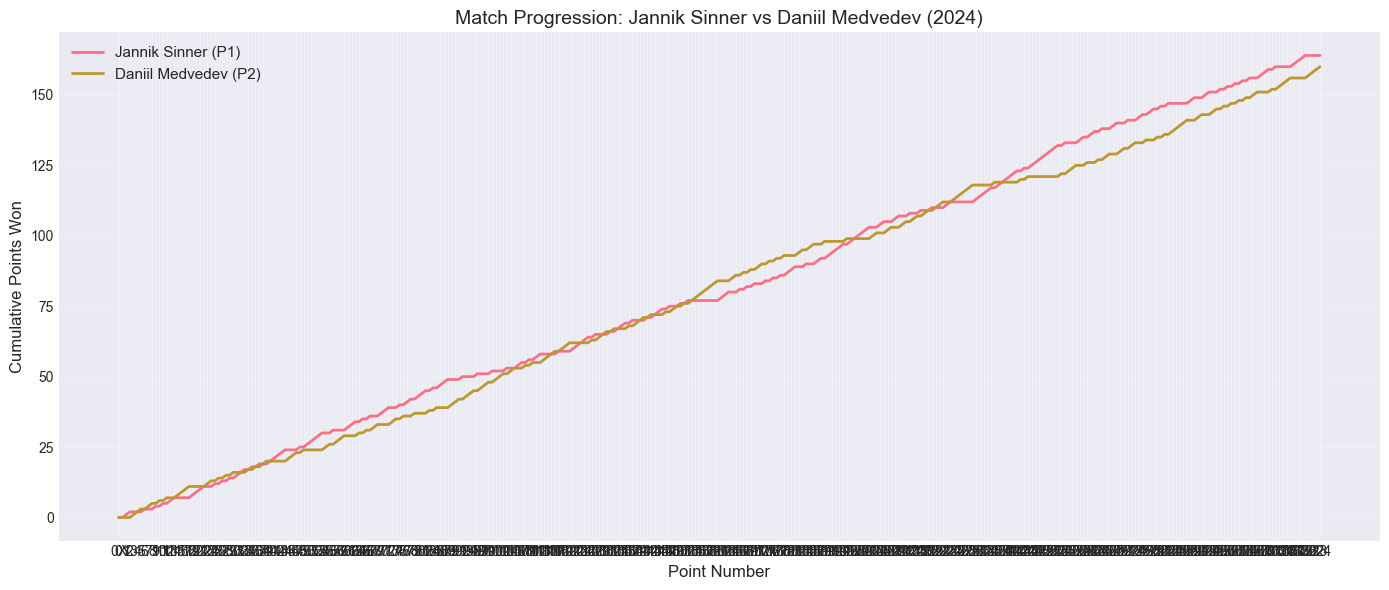

In [44]:
# Visualize point progression
plt.figure(figsize=(14, 6))

if 'P1PointsWon' in target_points.columns and 'P2PointsWon' in target_points.columns:
    plt.plot(target_points['PointNumber'], target_points['P1PointsWon'], 
             label=f'{player1} (P1)', linewidth=2)
    plt.plot(target_points['PointNumber'], target_points['P2PointsWon'], 
             label=f'{player2} (P2)', linewidth=2)
    
    plt.xlabel('Point Number', fontsize=12)
    plt.ylabel('Cumulative Points Won', fontsize=12)
    plt.title(f'Match Progression: {player1} vs {player2} (2024)', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("PointsWon columns not available for visualization")

## 13. Summary & Next Steps

In [45]:
print("=" * 80)
print("DATA EXPLORATION SUMMARY")
print("=" * 80)

print(f"\n✅ Target Match Confirmed: {TARGET_MATCH_ID}")
print(f"   Players: {player1} vs {player2}")
print(f"   Points: {len(target_points)}")

print(f"\n✅ 2023 Historical Data Available:")
print(f"   {player1}: {len(player1_2023_matches)} matches, {len(player1_points_2023)} points")
print(f"   {player2}: {len(player2_2023_matches)} matches, {len(player2_points_2023)} points")

print(f"\n✅ Data Quality Fixed & Validated:")
print(f"   - P1FirstSrvIn/P2FirstSrvIn calculated from ServeNumber (per-point logic)")
print(f"   - Validation: {valid_2024 and valid_2023} (20 matches checked per dataset, <10% fail rate)")
print(f"   - Corrected datasets saved to {CORRECTED_DIR}")
print(f"   - Post-correction quality check: PASSED (both 2023 and 2024)")

print("\n📋 NEXT STEPS:")
print("   1. Notebook 2: Extract Beta priors from 2023 corrected data")
print("   2. Notebook 3: Engineer running statistics for target match")
print("   3. Notebook 4: Build PyMC Bayesian model")
print("   4. Notebook 5: Visualize posterior convergence")

print("\n⚠️  CRITICAL: All downstream notebooks must load from:")
print(f"   {CORRECTED_DIR}/2023-wimbledon-points-corrected.csv")
print(f"   {CORRECTED_DIR}/2024-wimbledon-points-corrected.csv")
print("\n" + "=" * 80)

DATA EXPLORATION SUMMARY

✅ Target Match Confirmed: 2024-wimbledon-1501
   Players: Jannik Sinner vs Daniil Medvedev
   Points: 326

✅ 2023 Historical Data Available:
   Jannik Sinner: 6 matches, 1144 points
   Daniil Medvedev: 6 matches, 1210 points

✅ Data Quality Fixed & Validated:
   - P1FirstSrvIn/P2FirstSrvIn calculated from ServeNumber (per-point logic)
   - Validation: True (20 matches checked per dataset, <10% fail rate)
   - Corrected datasets saved to /Users/egeaydin/Github/TUW2025WS/aip_ege/data/corrected
   - Post-correction quality check: PASSED (both 2023 and 2024)

📋 NEXT STEPS:
   1. Notebook 2: Extract Beta priors from 2023 corrected data
   2. Notebook 3: Engineer running statistics for target match
   3. Notebook 4: Build PyMC Bayesian model
   4. Notebook 5: Visualize posterior convergence

⚠️  CRITICAL: All downstream notebooks must load from:
   /Users/egeaydin/Github/TUW2025WS/aip_ege/data/corrected/2023-wimbledon-points-corrected.csv
   /Users/egeaydin/Github/T

In [46]:
# Save key variables for next notebook
import pickle

exploration_data = {
    'target_match_id': TARGET_MATCH_ID,
    'player1': player1,
    'player2': player2,
    'player1_match_ids_2023': player1_match_ids.tolist(),
    'player2_match_ids_2023': player2_match_ids.tolist(),
    'target_point_count': len(target_points),
    'corrected_data_path': str(CORRECTED_DIR)
}

output_path = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/src/exploration_data.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(exploration_data, f)

print(f"✅ Exploration data saved to: {output_path}")

✅ Exploration data saved to: /Users/egeaydin/Github/TUW2025WS/aip_ege/src/exploration_data.pkl
